# Identification of Grape Diseases with CNN Model

## 📊 Loading Datasets

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define functions for loading and resizing images
def load_and_resize_image(file_path, target_shape=(128, 128)):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, target_shape)
    return resized_image

In [3]:
# Define the function to load each image class (target) stored by individual directory. 
# Each class directory containing their respective images
def load_image_class_by_directory(image_dir):
    # Load and resize images
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG'):  # Assuming images are in jpg or JPG format
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)
            images.append(resized_image)

    print(f"Num of images: {len(images)}")        
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [4]:
# Display some images
def display_images(images, num_images_to_display = 6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        # Convert the image to a supported depth (e.g., CV_8U) before color conversion
        image = images[i].astype(np.uint8)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with matplotlib
        axes[i].axis('off')
    plt.show()

Num of images: 1180
Single image shape before flattening: (128, 128, 3)


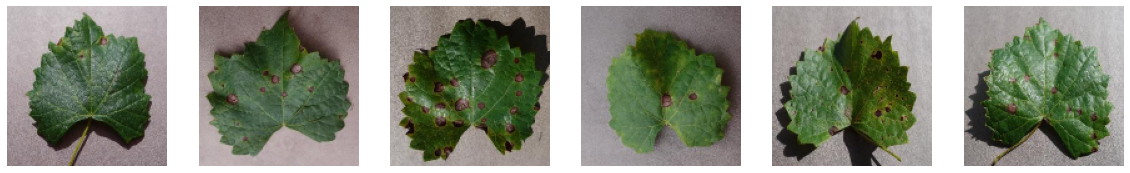

In [5]:
# Define the directory containing images
image_dir = "/blue/bsc4892/seanwang/final_project/grape_disease/pictures/Grape_Black_rot"
images_Black_Rot = load_image_class_by_directory(image_dir)
display_images(images_Black_Rot)

Num of images: 1383
Single image shape before flattening: (128, 128, 3)


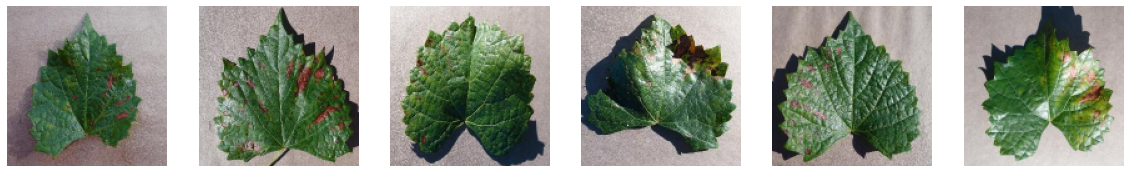

In [6]:
# Define the directory containing images
image_dir = "/blue/bsc4892/seanwang/final_project/grape_disease/pictures/Grape_Esca_(Black_Measles)"
images_Esca = load_image_class_by_directory(image_dir)
display_images(images_Esca)

Num of images: 1076
Single image shape before flattening: (128, 128, 3)


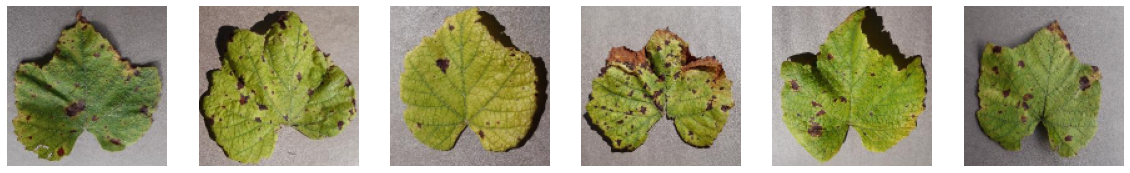

In [7]:
# Define the directory containing images
image_dir = "/blue/bsc4892/seanwang/final_project/grape_disease/pictures/Grape_Leaf_blight_(Isariopsis_Leaf_Spot)"
images_Blight = load_image_class_by_directory(image_dir)
display_images(images_Blight)

Num of images: 1000
Single image shape before flattening: (128, 128, 3)


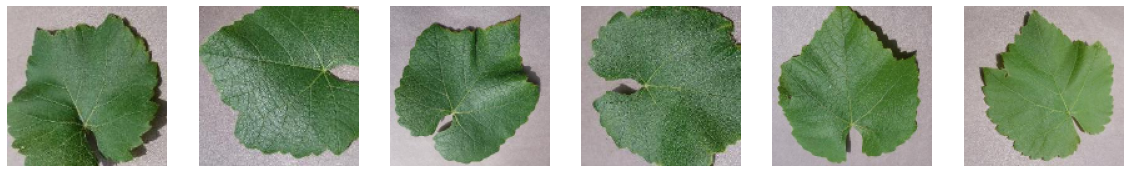

In [8]:
# Define the directory containing images
image_dir = "/blue/bsc4892/seanwang/final_project/grape_disease/pictures/Grape_healthy"
images_healthy = load_image_class_by_directory(image_dir)
display_images(images_healthy)

## 🍃 Calculating The Numbers of Samples

In [10]:
# Define class labels
classes = {'Blight': 0, 'Esca': 1, 'Black_Rot': 2, 'Healthy': 3} 
inverted_classes = {0: 'Blight', 1: 'Esca', 2: 'Black_Rot', 3: 'Healthy'}

images_lst_lst = [images_Blight, images_Esca, images_Black_Rot, images_healthy]

# Dictionary to store the number of image samples
classes_dict = {}
for i, images in enumerate(images_lst_lst):
    classes_dict.update({inverted_classes[i]: len(images)})
    print(f'Disease: {inverted_classes[i]} --- Images: {len(images)}')

Disease: Blight --- Images: 1076
Disease: Esca --- Images: 1383
Disease: Black_Rot --- Images: 1180
Disease: Healthy --- Images: 1000


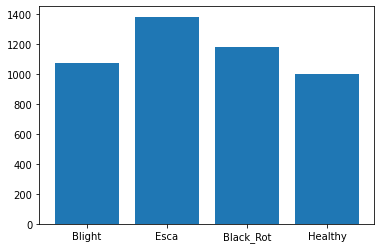

In [11]:
# Now, plot the classes
plt.bar(*zip(*classes_dict.items()))
plt.show()

There is a **class imbalance** with fewer cases of **Gray_Leaf_Spot**. This may affect model's ability to recognize the class, or do so with high confidence at least.

# 🏷️ Assigning Class Labels
Pick the number of images to set aside as **test** set. The algorithm should not see this data as it will be used for later evaluations.

Add a class label for each image. This is done by first flattening the image from 2D to 1D, and then appending the class number to it (such as 0 for Blight, etc.)

In [12]:
# Function to flatten the RGB values from 2D to 1D, returns a numpy array
def flatten_images(images):
    data_flattened = []
    for image in images:
        flattened_image = image.reshape(-1)  # Flatten the image
        data_flattened.append(flattened_image)
        
        
    print(f"Num of images: {len(data_flattened)}")
    print(f"Single image shape after flattening: {data_flattened[0].shape}")
    
    # Convert data to numpy array for further processing
    data_flattened = np.array(data_flattened)
    return data_flattened

In [13]:
# Function to assign class labels: returns a numpy array
def assign_image_class_label(images, class_label = int):
    data_labeled = []
    # Flatten the images
    data_flattened = flatten_images(images)
    
    for image in data_flattened:
        # Assign class label
        data_labeled.append(np.concatenate([image, [class_label]]))
    
    print(f"Num of images: {len(data_labeled)}")
    print(f"Single data shape with label: {data_labeled[0].shape} --- Class label: {class_label}\n")
    
    # Convert data to numpy array for further processing
    data_labeled = np.array(data_labeled)
    return data_labeled

In [14]:
# Function to concatenate the arrays into a pandas dataframe, horizontally
def concat_arrays_to_dataframe(arrays = []):
    # Combine to a single dataframe, vertically
    dataset = np.concatenate(arrays, axis = 0)

    # Number of pixel columns, excluding the last label column
    num_pix = dataset.shape[1] - 1

    # Modify the column names
    col_lst = [f"pixel{col}" for col in range(num_pix)]
    # Append the name of the last column as label
    col_lst.append("label")

    # Convert to a dataframe and add column names
    df_dataset = pd.DataFrame(dataset, columns = col_lst)
    
    return df_dataset

In [15]:
# Split the image files into train - test set.
def split_train_test_files(images_lst_lst = [], num_test_set = int):
    train_images_lst_lst = []
    test_images_lst_lst = []
    # Iterate through the first class of images
    for images in images_lst_lst:
        train_set = images[num_test_set:]
        test_set = images[:num_test_set]
        
        train_images_lst_lst.append(train_set)
        test_images_lst_lst.append(test_set)
        
    return train_images_lst_lst, test_images_lst_lst

In [16]:
# Number of images to set aside as test set per class
num_test_set = 20

# Split the image files into train - test set.
train_images, test_images = split_train_test_files(images_lst_lst, num_test_set)

In [17]:
images_lst_array = []
# Iterate through the classes, the class index i will represent the class name/label
for i, images in enumerate(train_images):
    # Assign label to each of the images
    labeled = assign_image_class_label(images, i)
    images_lst_array.append(labeled)

Num of images: 1056
Single image shape after flattening: (49152,)
Num of images: 1056
Single data shape with label: (49153,) --- Class label: 0

Num of images: 1363
Single image shape after flattening: (49152,)
Num of images: 1363
Single data shape with label: (49153,) --- Class label: 1

Num of images: 1160
Single image shape after flattening: (49152,)
Num of images: 1160
Single data shape with label: (49153,) --- Class label: 2

Num of images: 980
Single image shape after flattening: (49152,)
Num of images: 980
Single data shape with label: (49153,) --- Class label: 3



In [18]:
# Concatenate arrays to dataframe
df_images = concat_arrays_to_dataframe(images_lst_array)
df_images.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel49143,pixel49144,pixel49145,pixel49146,pixel49147,pixel49148,pixel49149,pixel49150,pixel49151,label
0,116,113,128,118,115,130,125,122,137,120,...,168,164,170,163,159,165,163,159,165,0
1,166,169,173,169,172,176,165,168,172,164,...,64,65,69,60,61,65,54,55,59,0
2,125,127,137,122,124,134,120,122,132,121,...,209,207,207,208,206,206,204,202,202,0
3,199,197,197,199,197,197,199,197,197,205,...,131,134,139,124,127,132,132,135,140,0
4,142,143,153,124,125,135,141,142,152,141,...,193,198,201,200,205,208,196,201,204,0


## ✂️ Train and Test Split

In [19]:
from sklearn.model_selection import train_test_split
import random

In [20]:
X_images = df_images.drop("label", axis = 1)
y_images = df_images["label"]

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_images, y_images, test_size = 0.25, random_state = 2, shuffle=True)
print("Shape of train X:", X_train.shape)
print("Shape of train Y:", y_train.shape)
print("Shape of val X:", X_val.shape)
print("Shape of val Y:", y_val.shape)

Shape of train X: (3419, 49152)
Shape of train Y: (3419,)
Shape of val X: (1140, 49152)
Shape of val Y: (1140,)


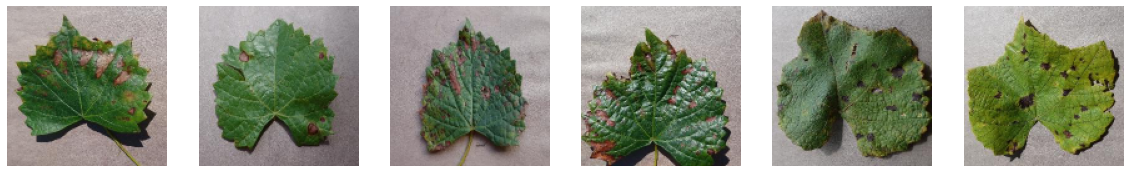

In [22]:
# Display some images before scaling
X_train_RGB = np.array(X_train).reshape(-1, 128, 128, 3)
display_images(X_train_RGB)

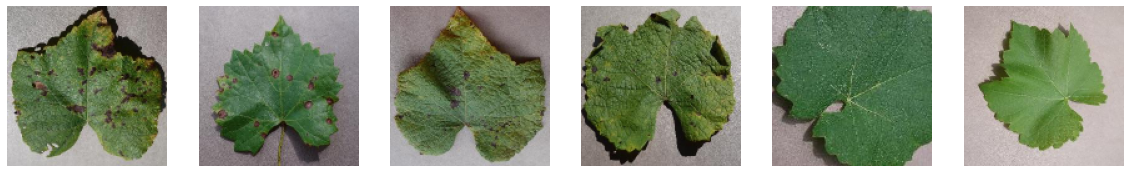

In [23]:
# Display some images before scaling
X_val_RGB = np.array(X_val).reshape(-1, 128, 128, 3)
display_images(X_val_RGB)

## 📖 Normalizing Dataset

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
# The pixel values ranges from 0 to 255. The MinMaxScaler makes it from 0 to 1. 
# This reduces the magnitude sensitivity of the activation function for the choosen ML algorithm.
scaler = MinMaxScaler(feature_range = (0, 1))

# Convert to numpy array to remove feature names before fitting
scaler = scaler.fit(np.array(X_train))
X_train_np = scaler.transform(np.array(X_train))
X_val_np = scaler.transform(np.array(X_val))

# Reshape to RGB format
X_train_RGB = np.array(X_train_np).reshape(-1, 128, 128, 3)
X_val_RGB = np.array(X_val_np).reshape(-1, 128, 128, 3)

# Reshape targets
y_train = y_train.values.reshape(len(y_train), 1)
y_val = y_val.values.reshape(len(y_val), 1)

In [26]:
print("Shape of train X:", X_train_RGB.shape)
print("Shape of train Y:", y_train.shape)
print("Shape of val X:", X_val_RGB.shape)
print("Shape of val Y:", y_val.shape)

Shape of train X: (3419, 128, 128, 3)
Shape of train Y: (3419, 1)
Shape of val X: (1140, 128, 128, 3)
Shape of val Y: (1140, 1)


## 🏠 Building Model

In [26]:
!pip install typing_extensions

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [27]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# To avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping 

# Target variable needs one-hot encoding to ensure each example has a probability of 1.0 for its actual class and 0.0 for others.
# Use Keras to_categorical() function for achieving this.
from tensorflow.keras.utils import to_categorical

# Draw live chart of accuracy of neural network
from livelossplot import PlotLossesKeras

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


2024-04-22 15:44:15.913807: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 15:44:16.148055: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 15:44:17.188119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 15:44:20.742928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
# Shape of a single image
input_shape = X_train_RGB[0].shape
num_train_images = len(X_train_RGB)
# Number of classes to be predicted
num_classes = 4
print(f'Single image shape: {input_shape}')
print(f'Number of train images: {num_train_images}')

Single image shape: (128, 128, 3)
Number of train images: 3419


Here comes the model architecture and its components.

In [29]:
# Initialize the sequential model
model = Sequential() 

# Add an input layer with the specified input shape
model.add(Input(shape=input_shape))

# Add a convolutional layer with 128 filters of size 3x3, using ReLU activation function
model.add(Conv2D(128, (3, 3), activation="relu"))

# Add a max-pooling layer with a filter size of 2x2
model.add(MaxPooling2D((2, 2)))

# Add dropout regularization to randomly omit neurons
model.add(Dropout(0.5))

# Add another convolutional layer with 64 filters of size 3x3, using ReLU activation function
model.add(Conv2D(64, (3, 3), activation="relu"))          

# Add another max-pooling layer with a filter size of 2x2
model.add(MaxPooling2D((2, 2)))

# Add dropout regularization to randomly omit neurons
model.add(Dropout(0.5))

# Flatten the output of the previous layers
model.add(Flatten())

# Add a dense layer with 256 neurons and ReLU activation function
model.add(Dense(256, activation="relu"))

# Add dropout regularization to randomly omit neurons
model.add(Dropout(0.5))

# Add a dense output layer with the number of classes and softmax activation function
model.add(Dense(num_classes, activation="softmax"))

# Compile the model with categorical crossentropy loss and Stochastic Gradient Descent optimizer
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Display a summary of the model architecture
model.summary()

2024-04-22 15:44:32.475876: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,824,260 (56.55 MB)

 Trainable params: 14,824,260 (56.55 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Initialize Image Augmentation
train_datagen = ImageDataGenerator(rotation_range = 10,  # rotation
                                   width_shift_range = 0.1,  # horizontal shift
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1) # zoom

In [31]:
# Initialize regularization parameters - how many epochs to wait before training stops, if there is no further improvement
monitor_val_loss = EarlyStopping(monitor = "val_loss", 
                                 min_delta = 1e-3, 
                                 patience = 20, # Wait 5 more epochs
                                 verbose = 1, 
                                 mode = "auto", 
                                 restore_best_weights = True)

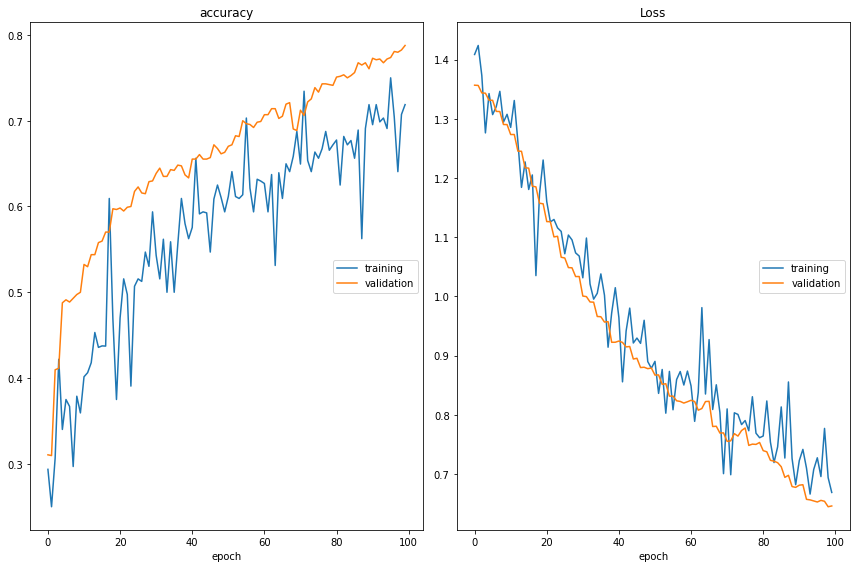

accuracy
	training         	 (min:    0.250, max:    0.750, cur:    0.719)
	validation       	 (min:    0.310, max:    0.788, cur:    0.788)
Loss
	training         	 (min:    0.666, max:    1.424, cur:    0.669)
	validation       	 (min:    0.645, max:    1.357, cur:    0.646)
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.7188 - loss: 0.6690 - val_accuracy: 0.7877 - val_loss: 0.6462
Restoring model weights from the end of the best epoch: 99.


In [32]:
# Target variable needs one-hot encoding to ensure each example has a probability of 1.0 for its actual class and 0.0 for others.
# Use Keras to_categorical() function for achieving this.

epochs = 100
batch_size = 64

# Using the flow method to augment the image on the fly.
training_data = train_datagen.flow(X_train_RGB, to_categorical(y_train), batch_size = batch_size)
# Model evaluation
validation_data = (X_val_RGB, to_categorical(y_val))

history = model.fit(training_data,
                    epochs = epochs,
                    steps_per_epoch = num_train_images // batch_size, # Number of iterations per epoch
                    batch_size = batch_size,
                    validation_data = validation_data, 
                    callbacks = [PlotLossesKeras(), monitor_val_loss], #live chart
                    verbose = 1
                   )

In [33]:
# Save model
model.export('/blue/bsc4892/seanwang/final_project/grape_disease/model/')

INFO:tensorflow:Assets written to: /blue/bsc4892/seanwang/final_project/grape_disease/model/assets


INFO:tensorflow:Assets written to: /blue/bsc4892/seanwang/final_project/grape_disease/model/assets


Saved artifact at '/blue/bsc4892/seanwang/final_project/grape_disease/model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  23303579348032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303579352256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303579676944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303579677296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303579854704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303579853472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303580093072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23303580091488: TensorSpec(shape=(), dtype=tf.resource, name=None)


## 🤔 Evaluating Model
Recall that first n images haven't been seen by the algorithm.

In [34]:
# Function to scale and reshape the images for each class
def scale_and_reshape_images(flattened_images_lst = []):
    images_scaled_RGB_lst = []
    for images in flattened_images_lst:
        # Scale images using same scaller used for the train and val set
        images_scaled = scaler.transform(images)
        # Reshape to RGB format
        images_scaled_RGB = np.array(images_scaled).reshape(-1, 128, 128, 3)
        
        images_scaled_RGB_lst.append(images_scaled_RGB)
    return images_scaled_RGB_lst

In [35]:
# Display a single image
def display_image(image_single):
    image_flat = image_single.reshape(1, -1) # Flatten image
    image_inv = scaler.inverse_transform(image_flat) # Inverse transform image
    image_reshaped = image_inv.reshape(128, 128, 3)
    
    image = image_reshaped.astype(np.uint8)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    plt.show()

In [36]:
# Interprete model prediction: returns the predicted class and the confidence level in %
def interpret_model_prediction(predictions):
    # Convert inferences to list and 
    pred_lst = predictions[0,:].tolist()
    # Get the max value
    max_proba = max(pred_lst)
    # Get the index position of the max_probability
    pred_idx = pred_lst.index(max_proba)
    
    return pred_idx, max_proba

In [37]:
# Define the function to make the inferences/predictions. 
# Takes the actual value (String) and the image index (int from 0 to n, where n is the num_test_set)
def make_predictions(scaled_RGB_lst, image_class = '', image_idx = int):
    # Get the numerical value of the class form the defined classes dictionary
    class_val = classes[image_class]
    
    # Get the single image
    image_single = scaled_RGB_lst[class_val][image_idx]
    
    # Make prediction for one image. Has to be reshaped
    pred = model.predict(image_single.reshape(1, 128, 128, 3))
    
    # Interpret model predictions
    pred_class, confidence = interpret_model_prediction(pred)
    
    # Display image
    display_image(image_single)
    
    print(f"Actual: {image_class}")
    print(f"Predicted: {list(classes.keys())[pred_class]}")
    print(f'Confidence: {round(confidence, 4)}')

In [38]:
# Flatten the images
images_lst_array = []
for images in test_images:
    # Function returns two values
    flattened = flatten_images(images) # num_test_set is the number of images set aside as test set

    images_lst_array.append(flattened)

Num of images: 20
Single image shape after flattening: (49152,)
Num of images: 20
Single image shape after flattening: (49152,)
Num of images: 20
Single image shape after flattening: (49152,)
Num of images: 20
Single image shape after flattening: (49152,)


In [39]:
# Normalize and reshape the images for each class
images_scaled_RGB_lst = scale_and_reshape_images(images_lst_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


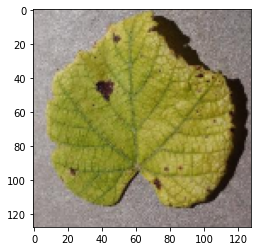

Actual: Blight
Predicted: Blight
Confidence: 0.9944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


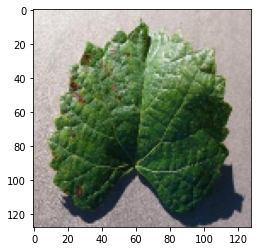

Actual: Esca
Predicted: Esca
Confidence: 0.5273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


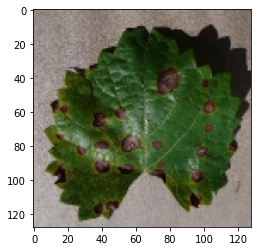

Actual: Black_Rot
Predicted: Black_Rot
Confidence: 0.3839
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


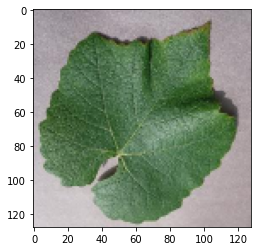

Actual: Healthy
Predicted: Healthy
Confidence: 0.8266


In [40]:
# Keys from the classes dictionary defined above
class_keys = list(classes.keys())
# Image index from the test set 
image_idx = 2
for key in class_keys:
    make_predictions(images_scaled_RGB_lst, key, image_idx)